In [1]:
import os
import torch
from ochuman_dataset import OCHumanDataset
from utils.misc import collate_fn
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
from json import JSONEncoder
#instruction:original images under dataset1/images/test
#NST images under dataset2/images/test
#create out_json and out_NST file under./src
#the sequence of original images and NST images better be same

In [2]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [15]:
def show_img(index, images, outputs, cpu_device=torch.device("cpu")):
    overall_mask = np.zeros((600, 600, 1))
    for i in range(len(outputs)):
        for j in range(len(outputs[i]["masks"])):
            mask = outputs[i]["masks"][j].to(cpu_device).permute(1, 2, 0).detach().numpy()
            overall_mask[mask >= 0.25] = 1
        print(f"Image ID: {index}, Number of masks: {j + 1}")
        overall_mask[overall_mask > 0] = 1
        overall_mask = np.squeeze(overall_mask)

        img = images[i].to(cpu_device).permute(1, 2, 0).numpy()
        img *= 255

        # add cyan to img and save as new image
        blend = 0.65
        cyan = np.full_like(img,(255,255,0))
        img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
        
        idx = (overall_mask == 1)
        img[idx] = img_cyan[idx]

        with open(os.path.join("./out_json", f"{index}_{i}.json"),"w") as write_file:
            json.dump(overall_mask, write_file, cls=NumpyArrayEncoder)


        cv2.imwrite(os.path.join("./out", f"{index}_{i}.jpg"), img[:, :, ::-1])

In [17]:
def show_img_NST(index, images, outputs, cpu_device=torch.device("cpu")):
    overall_mask = np.zeros((600, 600, 1))
    for i in range(len(outputs)):
        for j in range(len(outputs[i]["masks"])):
            mask = outputs[i]["masks"][j].to(cpu_device).permute(1, 2, 0).detach().numpy()
            mask[mask >= 0.25] = 1
            mask[mask < 0.25] = 0
            overall_mask += mask
            print(f"Number of masks: {j + 1}")

        img = images[i].to(cpu_device).permute(1, 2, 0).numpy()
        img *= 255

        cv2.imwrite(os.path.join("./out_NST", f"{index}_{i}.jpg"), img[:, :, ::-1])

In [21]:
if __name__ == "__main__":
    file_ids = []
    for _, _, file_names in os.walk(os.path.join("./dataset1")):
        for file_name in file_names:
            file_ids.append(file_name.split(".")[0])

    file_ids_NST = []
    for _, _, file_names in os.walk(os.path.join("./dataset2")):
        for file_name in file_names:
            file_ids_NST.append(file_name.split(".")[0])

    dataset_test = OCHumanDataset(
                        root_dir="./dataset1/",
                        img_ids=file_ids,
                        transforms=None,
                        train=False
                    )

    dataset_test_NST = OCHumanDataset(
                        root_dir="./dataset2/",
                        img_ids=file_ids_NST,
                        transforms=None,
                        train=False
                    )

    data_loader_test = torch.utils.data.DataLoader(
                        dataset_test, 
                        batch_size=1, 
                        shuffle=False, 
                        num_workers=1,
                        collate_fn = collate_fn
                    )

    data_loader_test_NST = torch.utils.data.DataLoader(
                        dataset_test_NST, 
                        batch_size=1, 
                        shuffle=False, 
                        num_workers=1,
                        collate_fn = collate_fn
                    )

    device = torch.device("cuda")
    cpu_device = torch.device("cpu") 

    with torch.no_grad():
        model = torch.load("./out/weights/100.pth")
        model.to(device)
        model.eval()

        for i, (images, targets) in enumerate(data_loader_test):
            print(i)
            images = list(img.to(device) for img in images)
            outputs = model(images)
            show_img(i, images, outputs) 

        for i, (images, targets) in enumerate(data_loader_test_NST):
            print(i)
            images = list(img.to(device) for img in images)
            outputs = model(images)
            show_img_NST(i, images, outputs) 

0
Image ID: 0, Number of masks: 5
0
Number of masks: 1
Number of masks: 2
Number of masks: 3


(600, 600, 3)


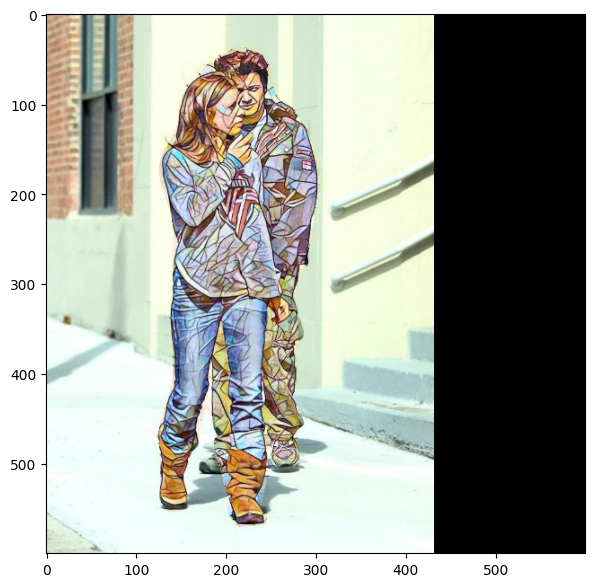

In [22]:
img1=cv2.imread("C:/Users/WanyingMo/Desktop/MaskRCNN-PyTorch/src/out/0_0.jpg")[:,:,::-1]
img2=cv2.imread("C:/Users/WanyingMo/Desktop/MaskRCNN-PyTorch/src/out_NST/0_0.jpg")[:,:,::-1]
with open("C:/Users/WanyingMo/Desktop/MaskRCNN-PyTorch/src/out_json/0_0.json") as f:
    mask = json.load(f)
print(np.shape(img1))
for i in range(np.shape(mask)[0]):
    for j in range(np.shape(mask)[1]):
        if mask[i][j] == 0:
            img2[i][j] = img1[i][j]
plt.figure(figsize = (7, 7))
plt.imshow(img2) 